# Module: calibration

This module contains functions for calibration of 4DSTEM data, including calibrating pixel sizes, calibrating the rotational offset between the real and diffraction planes, correcting diffraction shifts, and correcting elliptical distortions.

### Correct ellitical distortions, with a beam stop

This notebook demos measuring and correction elliptical distortion of the diffraction patterns due to imperfect electron optics.  This notebook requires that the Bragg peaks and Bragg vector map have already been measured, and if necessary, the diffraction shifts corrected.

### Import packages, load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import py4DSTEM
import scipy.optimize as sciopt
from py4DSTEM.process.utils import print_progress_bar
from scipy.signal import convolve2d

from py4DSTEM.process.utils import polar_elliptical_transform

In [2]:
# Get data and masks

#fp = "/home/lerandc/Downloads/data_polar_test.mat"
fp = "/media/lerandc/DATA/files/Amorphous_simulations/Ta_sim_sa_051.h5"
browser = py4DSTEM.file.io.FileBrowser(fp)
datacube = browser.get_dataobject('CBED_array_depth0008')


In [3]:
browser.show_dataobjects()

 Index                  Name                        Type        
   0    CBED_array_depth0000                DataCube            
   1    CBED_array_depth0001                DataCube            
   2    CBED_array_depth0002                DataCube            
   3    CBED_array_depth0003                DataCube            
   4    CBED_array_depth0004                DataCube            
   5    CBED_array_depth0005                DataCube            
   6    CBED_array_depth0006                DataCube            
   7    CBED_array_depth0007                DataCube            
   8    CBED_array_depth0008                DataCube            


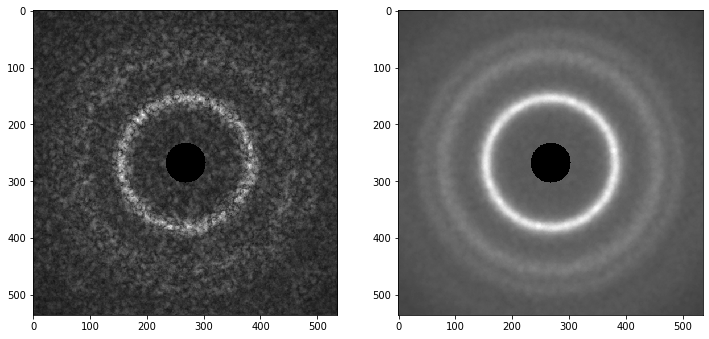

In [4]:
offset = 1 #pixels
cubeShape = datacube.data.shape
#datacube.data *= 5e5
yy,xx = np.meshgrid(np.arange(cubeShape[2]),np.arange(cubeShape[3]))
yy = yy - cubeShape[2]//2
xx = xx - cubeShape[3]//2
rr = np.sqrt(xx**2+yy**2)
mask = rr > 35
fit_mask = np.logical_and(rr> 50, rr < 175)
CBEDmean = np.mean(datacube.data,axis=(0,1))
fig,(ax11,ax12) = plt.subplots(1,2,figsize=(12,12))
ax11.imshow(mask*datacube.data[0,0,:,:]**0.4)
ax12.imshow(mask*CBEDmean**0.4)

In [5]:
ar = CBEDmean
mask = fit_mask

In [6]:
print(CBEDmean.shape)
print(1792*0.07494567/2)

(536, 536)
67.15132032000001


In [7]:
# Get initial polar transform
### Params ###
x0_init=None
y0_init=None
dr= 1             # in pixels
dtheta= 2.5       # in degrees
r_range=250      # either [min,max] or just max --> [0,max]
##############

# Perform transform
pet = polar_elliptical_transform(calibration_image=ar,
                                 mask=mask,
                                 x0_init=x0_init,
                                 y0_init=y0_init,
                                 dr=dr,
                                 dtheta=dtheta,
                                 r_range=r_range)
transform_mask = rr > 35
pet.get_polar_transform(mask=transform_mask)

In [8]:
# Fit center

#### Params ####
n_iter=50
step_sizes_init = [1, 1]    # Initial step sizes [dx,dy] for the origin
step_scale=0.9              # If no step is taken, reduce step sizes by this fraction
################

# Perform fit
scores,x_vals,y_vals = pet.fit_origin(n_iter=n_iter,
                                      step_sizes_init=step_sizes_init,
                                      step_scale=step_scale,
                                      return_ans=True)

Analyzing: |**************************************************| 100.0% Complete


In [9]:
# Fit all coefficients

#### Params ####
n_iter=50
step_sizes_init = [0.1, 0.1, 0, 0.1, 0.1]    # Initial step sizes for [x0,y0,A,B,C] 
step_scale=0.9                               # If no step is taken, reduce step sizes by this fraction
################

# Perform fit
scores,x_vals,y_vals,A_vals,B_vals,C_vals = pet.fit_params(n_iter=n_iter,
                                                           step_sizes_init=step_sizes_init,
                                                           step_scale=step_scale,
                                                           return_ans=True)

Analyzing: |**************************************************| 100.0% Complete


In [10]:
def addPoissonNoise(orig,scale):
    #applies poisson noise after first scaling image array from [0,x] to [0,scale]
    #orig is noiseless image matrix, scale is scaling factor to assign discrete probablities of electron counts
    #returns noisy image array
    if scale > 0.0:
        scale /= np.max(orig)
        orig = orig * scale
        noisy = np.random.poisson(orig)
        return noisy
    return orig

In [11]:
#polar CBED mean is the calibration image currently
polarCBED_var = np.zeros(pet.polar_ar.shape)
polarCBEDmean = pet.polar_ar
CBED_stack = np.reshape(datacube.data,(cubeShape[0]*cubeShape[1],cubeShape[2],cubeShape[3]))
CBED_stack_noisy = np.copy(CBED_stack)


#apply poisson noise
scale = 1500
for i in range(CBED_stack_noisy.shape[0]):
    CBED_stack_noisy[i,:,:] = addPoissonNoise(transform_mask*CBED_stack[i,:,:],scale)
    
CBEDmean_noisy = np.mean(CBED_stack_noisy,axis=0)
polarCBEDmean_noisy, __ = pet.get_polar_transform(ar=CBEDmean_noisy,mask=transform_mask,return_ans=True)
for i in range(CBED_stack.shape[0]):
    tmp_ar, _ = pet.get_polar_transform(ar=(CBED_stack_noisy[i,:,:]),mask=transform_mask,return_ans = True)
    polarCBED_var = polarCBED_var + (tmp_ar - polarCBEDmean_noisy)**2
    
polarCBED_var = polarCBED_var / CBED_stack.shape[0]

0.003722934729880599


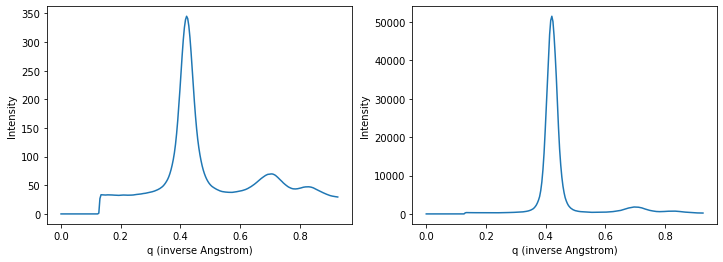

In [12]:
polarCBED_var.shape
yMean = np.mean(pet.polar_mask*polarCBEDmean_noisy,axis=0)
yVar = np.mean(pet.polar_mask*polarCBED_var,axis=0)
yNorm = np.mean(pet.polar_mask,axis=0)
pixelSize = 0.099927566964286 #0.074945675223214
E0 = 200e3
m = 9.109383e-31
e = 1.602177e-19
c = 299792458
h = 6.62607e-34
waveL =  (h / np.sqrt(2 * m * e * E0) / np.sqrt(1 + e * E0 / 2 / m / c / c) * 1e10)
dq = 1/(2688*pixelSize)#1/(2*ar.shape[0]*pixelSize) #2 times image shape due to antialiasing mask in prismatic
print(dq)
q_arr = np.arange(yMean.shape[0])*dq

fig1,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.plot(q_arr, yMean)
ax1.set_xlabel('q (inverse Angstrom)')
ax1.set_ylabel('Intensity')
ax2.plot(q_arr, yVar)
ax2.set_xlabel('q (inverse Angstrom)')
ax2.set_ylabel('Intensity')
# ax3.plot(np.arange(yMean.shape[0])*pixelSize, yNorm)
# ax4.matshow(pet.polar_mask)

#print(mask_ar.shape)
#plt.matshow(full_mask)
sub = yNorm > 1e-1
yMean[sub] = yMean[sub] / yNorm[sub]
yVar[sub] = yVar[sub] / yNorm[sub]
yVar[np.logical_not(sub)] = 0

yy = yVar

sub = yMean > 0


yy[sub] = yVar[sub] / (yMean[sub]**2)


In [13]:
print(np.max(q_arr)*waveL*1e3)
print(np.max(q_arr))
print(waveL)

23.248815276177684
0.9270107477402691
0.025079337357037376


In [14]:
from scipy.special import erf

symbol=['','H' , 'He' , 'Li' , 'Be' , 'B'  , 'C'  , 'N ' , 'O'  , 'F' , 'Ne',
           'Na', 'Mg' , 'Al' , 'Si' , 'P'  , 'S'  , 'Cl' , 'Ar' , 'K' , 'Ca',
           'Sc', 'Ti' , 'V'  , 'Cr' , 'Mn' , 'Fe' , 'Co' , 'Ni' , 'Cu', 'Zn',
           'Ga', 'Ge' , 'As' , 'Se' , 'Br' , 'Kr' , 'Rb' , 'Sr' , 'Y' , 'Zr',
           'Nb', 'Mo' , 'Tc' , 'Ru' , 'Rh' , 'Pd' , 'Ag' , 'Cd' , 'In', 'Sn',
           'Sb', 'Te' , 'I'  , 'Xe' , 'Cs' , 'Ba' , 'La' , 'Ce' , 'Pr', 'Nd',
           'Pm', 'Sm' , 'Eu' , 'Gd' , 'Tb' , 'Dy' , 'Ho' , 'Er' , 'Tm', 'Yb',
           'Lu', 'Hf' , 'Ta' , 'W'  , 'Re' , 'Os' , 'Ir' , 'Pt' , 'Au', 'Hg',
           'Tl', 'Pb' , 'Bi' , 'Po' , 'At' , 'Rn' , 'Fr' , 'Ra' , 'Ac', 'Th',
           'Pa', 'U'  , 'Np' , 'Pu' , 'Am' , 'Cm' , 'Bk' , 'Cf' , 'Es', 'Fm',
           'Md', 'No' , 'Lr' , 'Rf' , 'Db' , 'Sg' , 'Bh' , 'Hs' , 'Mt', 'Ds',
           'Rg', 'Uub', 'Uut', 'Uuq', 'Uup', 'Uuh', 'Uus', 'Uuo']

#Scattering factors taken from Lobato, I., & Van Dyck, D. (2014). An accurate
#parameterization for scattering factors, electron densities and electrostatic
#potentials for neutral atoms that obey all physical constraints. Acta
#Crystallographica Section A: Foundations and Advances, 70(6), 636-649.

#The array will be shaped such that ai and bi coefficients of the fit will sit
#along the
e_scattering_factors = np.asarray([
                6.47384848835291790e-03,    2.78519885379148890e+00,        -4.90192576780229040e-01,        2.77620428330644750e+00,        5.73284160390876480e-01,    2.77538591050625130e+00,        -3.79403301483990480e-01,    2.76759302867258810e+00,        5.54426474774079140e-01,    2.76511897642927540e+00,
                3.05745116099835460e+00,    1.08967248726078810e+00,        -6.20044779127325260e+01,        9.39838798143121100e-01,        6.40055537084614490e+01,    9.25289034386265530e-01,        -5.00132578542780590e+00,    8.22947498708650580e-01,        1.51798828700526440e-01,    5.77393110675402220e-01,
                3.92622272886147930e+00,    8.14276013517280360e+00,        -4.54861962639998030e+00,        4.98941077007855770e+00,        2.19335312878658510e+00,    4.14428999239410880e+00,        6.99451265033965710e-02,    4.01922315065680210e-01,        2.09864224851937560e-03,    1.56479034719823580e-01,
                3.39824970557054050e+00,    4.44270178622409520e+00,        -1.90866886095696660e+00,        3.32451542526422950e+00,        3.90702117539227370e-02,    1.89772880348214850e-01,        -1.11631010210714520e-02,    8.71918614644603550e-02,        9.46204465357523140e-03,    8.27809060041340560e-02,
                1.47279248639329290e+00,    3.74974048281819130e+00,        -4.01933042199387140e-01,        5.88066536139673750e-01,        3.05998956982689360e-01,    5.15639613103010990e-01,        1.96144217173168000e-02,    1.21377570080603680e-01,        9.77177106088202540e-04,    6.80982412160313910e-02,
                1.24466088621343300e+02,    2.42120849256005630e+00,        -2.20352857078963780e+02,        2.30537943752425800e+00,        1.95235352280479130e+02,    2.04851932106564230e+00,        -9.81079361269799650e+01,    1.93352552917547380e+00,        1.42023041213623150e-02,    7.68976818478339650e-02,
                5.81327150702556140e+01,    1.70044856413471050e+00,        -1.47542409087812730e+02,        1.55903852601740440e+00,        1.30143065649639450e+02,    1.41576827473146880e+00,        -3.96195674084154280e+01,    1.27841818205455790e+00,        1.05957763331480850e-02,    5.65587798474805540e-02,
                2.99474045242362440e+01,    1.30283987880010680e+00,        -7.76101266255278260e+01,        1.15794105258309530e+00,        9.98817764623144200e+01,    1.00988549338025120e+00,        -5.12127005505673050e+01,    9.43327971433265970e-01,        8.19618954446032010e-03,    4.33197611321825550e-02,
                9.48984894503524750e-01,    1.45882933198645910e+00,        -3.01333923043554930e+01,        6.88779993187680020e-01,        5.27965078127338640e+01,    6.54239869346695650e-01,        -2.27062703795272430e+01,    6.14836130811994290e-01,        6.56997664531440950e-03,    3.42837419495011160e-02,
                5.82741192220907370e-01,    1.28118573143877200e+00,        3.70676561841054910e-01,        4.44520897170477600e-01,        -5.46744967350809240e-01,    1.98650875510481020e-01,        4.14052682480208050e-01,    1.85477246656276460e-01,        5.19903080863993140e-03,    2.75738382033885800e-02,
                2.36700603946792610e+01,    8.45148773514603140e+00,    -2.18531786159742470e+01,    8.04096600474298210e+00,    5.92499448108946390e-01,    6.24996000526314990e-01,    -2.44652290310244000e-02,    1.32450394947296380e-01,    4.83950221706535770e-03,    2.33994362049878630e-02,
                4.85501047687149520e+00,    5.94639273842456450e+00,    -2.66220906476843670e+00,    4.17130312520697900e+00,    4.78001236085108030e-01,    3.98269808150374270e-01,    -7.02307064692064830e-02,    1.61886185837474190e-01,    3.98905828104019820e-03,    1.95345056363103450e-02,
                2.83409561607507500e+00,    6.66235023980533200e+00,    -4.28004133378261020e+00,    5.51294722224021430e-01,    4.42191680548311440e+00,    5.09328963445973780e-01,    -3.45774471896400580e-02,    1.11784837425331210e-01,    3.52385941406079890e-03,    1.67602351805257390e-02,
                2.87189142611612350e+00,    5.08487103642989610e+00,    -2.06173501195173530e+00,    4.29178185305126190e-01,    2.17114024204478720e+00,    3.66485434192162230e-01,    -6.63073633058801900e-02,    1.19710611296903400e-01,    3.01070709670513740e-03,    1.43994536128397540e-02,
                2.79151840023151410e+00,    3.90065961865466140e+00,    -4.36506837823822110e+00,    3.29825968377150000e-01,    4.43558455516699010e+00,    3.06089956505888550e-01,    -8.09635773399473850e-02,    1.08083232545972810e-01,    2.67900017966440440e-03,    1.25894495331186820e-02,
                2.67971415610199460e+00,    3.06889121199971140e+00,    -4.74252822230755160e-01,    3.78216702185809000e-01,    5.14835948989687650e-01,    1.88721811902548830e-01,    -9.58360024990722450e-02,    9.23370590031494100e-02,    2.48871963818935240e-03,    1.11920877241144090e-02,
                2.56624839980020260e+00,    2.41594920365612390e+00,    -3.38876350828591740e-01,    4.21414239310215990e-01,    1.14584558755515010e+00,    1.09592404975830310e-01,    -9.23109316547079620e-01,    9.90955458226752960e-02,    2.29168002041042150e-03,    9.99665948927521040e-03,
                2.45981746414068510e+00,    1.94004631988856560e+00,    -3.64198177076995090e-01,    3.99241067884398780e-01,    2.50584477222474460e-01,    1.17472406274412200e-01,    -5.77437029544345810e-02,    5.67803726023621840e-02,    2.30143866828583670e-03,    9.15579832920707970e-03,
                5.81107878601454790e+00,    1.26691483399036820e+01,    -5.02537096539422590e+01,    3.95641039698166490e+00,    4.88609412059842470e+01,    3.68385059577154510e+00,    7.40628592048382940e-02,    1.07458517569562820e-01,    7.27802738626221870e-04,    6.65576789391501140e-03,
                2.11781161524159530e+01,    6.39608619431736170e+00,    -3.39043824317468880e+02,    3.74024713891749450e+00,    3.22756958523296650e+02,    3.64888449922605270e+00,    6.50077673896996690e-02,    9.45090634514673540e-02,    6.55874366578593520e-04,    5.98520619883758600e-03,
                1.26035186572148630e+01,    6.15625615363852940e+00,    -2.76875382053702590e+02,    3.08873554266679310e+00,    2.68871603907342830e+02,    3.02727663298548320e+00,    5.56824178897458030e-02,    8.18874748375215680e-02,    5.77071255145399560e-04,    5.38289832050797570e-03,
                8.57595775238129930e+00,    6.00780668875581810e+00,    -2.10331563465304870e+02,    2.60285856745213010e+00,    2.06097172601541360e+02,    2.55352345051105620e+00,    4.77773948977261930e-02,    7.11429484024153900e-02,    5.05716484480320570e-04,    4.85628439383726120e-03,
                6.52768433234788950e+00,    5.83552479352448120e+00,    -2.00430576829172650e+02,    2.23255952381127630e+00,    1.98015053889994020e+02,    2.19786018594228990e+00,    4.13911518064005580e-02,    6.23973876828547300e-02,    4.47455024329856520e-04,    4.40383649079958020e-03,
                3.02831784843691310e+00,    8.35911504314631770e+00,    -9.55393933081432320e+01,    1.80263790264103240e+00,    9.61761562352198070e+01,    1.77509488957047210e+00,    3.59777315957987700e-02,    5.48144412143113730e-02,    3.91492890718422320e-04,    3.99828968916034810e-03,
                4.37417550633122690e+00,    5.51031705504928220e+00,    -1.60925510918779510e+02,    1.68798216402433910e+00,    1.60273308060322340e+02,    1.66614047777702390e+00,    3.12303861049162410e-02,    4.83370390321277020e-02,    3.46966021020938010e-04,    3.64746960053068160e-03,
                3.79810090836859620e+00,    5.31712645899433060e+00,    -9.16893549381687190e+01,    1.49713094884748130e+00,    9.14454252155429830e+01,    1.46809241804410510e+00,    2.72754344027604720e-02,    4.27247850128954910e-02,    3.03379854383771030e-04,    3.32791855231874110e-03,
                3.33037874467544270e+00,    5.18135964579543180e+00,    -7.70017596472967090e+01,    1.32915122265139420e+00,    7.70725221790516880e+01,    1.30284928963228920e+00,    2.39904669040569940e-02,    3.80645486826370960e-02,    2.68256665523942030e-04,    3.05010007991570780e-03,
                2.96908078725286370e+00,    5.04180949109380010e+00,    -7.57477069129040220e+01,    1.18275507921629310e+00,    7.60398287625307320e+01,    1.16216545846629930e+00,    2.10162113692966970e-02,    3.37479087883035340e-02,    2.31151751135153040e-04,    2.78680862070740520e-03,
                1.75207145212145600e+00,    6.18750497986187130e+00,    -4.30410523492124500e+01,    1.00266263628976620e+00,    4.40705915543573850e+01,    9.85384311353030280e-01,    1.86876154088144730e-02,    3.02984703916117610e-02,    2.01727324791624140e-04,    2.55855598748879050e-03,
                2.46637110499459130e+00,    4.91028078493815910e+00,    -6.14678541332537450e+01,    9.67898520322992170e-01,    6.20176945237481260e+01,    9.51283834775355500e-01,    1.64160173931416210e-02,    2.69600967667566260e-02,    1.72487117595380870e-04,    2.34109611046253710e-03,
                2.76010203108428340e+00,    6.10128224537662690e+00,    -3.44452614207467890e+01,    7.65143313553464880e-01,    3.52262267244016340e+01,    7.51328623382859660e-01,    1.32067196999419880e-02,    2.24879634317251170e-02,    1.25945560928245720e-04,    2.06737374278712340e-03,
                3.18241635260000020e+00,    5.01719040860914680e+00,    -5.24514037811166670e+01,    7.12395764437798170e-01,    5.29690827162218480e+01,    7.02280192528193960e-01,    1.14096168591864820e-02,    1.96747295694015350e-02,    9.50954358145057910e-05,    1.84146614494011450e-03,
                3.45642969119603950e+00,    4.01358016032945210e+00,    -3.33176044431721220e+01,    6.62355778050629060e-01,    3.35712193855332190e+01,    6.45771941056073830e-01,    9.79002295640342070e-03,    1.70919353231011460e-02,    6.53434862265172480e-05,    1.60301602839420070e-03,
                3.64905047801926410e+00,    3.25043267112593390e+00,    -4.36851662221238610e+01,    6.09666201650288950e-01,    4.36920288601154780e+01,    5.96971300802123240e-01,    8.44902284199144410e-03,    1.48554512740362250e-02,    3.78611474110038160e-05,    1.33625587356563020e-03,
                3.83846312224289490e+00,    2.61189470573232270e+00,    -5.22723471011233870e+01,    5.66195062874718210e-01,    5.19861279495659620e+01,    5.55279326699873900e-01,    7.33955989338044760e-03,    1.29746469432440690e-02,    1.64694207951339920e-05,    1.02986536855875730e-03,
                4.02541030310827440e+00,    2.13648381443739990e+00,    -4.63042332078929770e+01,    5.26591166454131180e-01,    4.57213681904101180e+01,    5.14136784464577560e-01,    6.35337959625315720e-03,    1.12807242242006810e-02,    1.33477845255742950e-06,    4.88089857940970360e-04,
                3.38975351595393980e+00,    2.05744814368171130e+01,    2.14348348679172410e+00,        1.91079945218516370e+00,    3.54322603510978160e-01,    1.97410589396603890e-01,    3.74009340085664200e-03,    8.13459465343988920e-03,    3.00342502342229660e-07,    2.92685791056951060e-04,
                4.77092509299825980e+00,    1.33668881330412750e+01,    1.47597850155283420e+00,        1.33738379577196680e+00,    3.04451355544188670e-01,    1.77532369437782830e-01,    3.59474981916728340e-03,    7.79105033001826780e-03,    3.00085549228278960e-07,    2.82255139648537230e-04,
                4.60721019875234020e+00,    1.08686905557151850e+01,    1.42801851039840270e+00,        1.31137455873124110e+00,    2.95581045577753830e-01,    1.68022870784711150e-01,    3.38997840852895120e-03,    7.35964545350478290e-03,    2.66862974969022400e-07,    2.62343281021387260e-04,
                4.31175453406871600e+00,    9.45896580517490190e+00,    1.49331578039339450e+00,        1.33063622845245620e+00,    2.81236050128884140e-01,    1.56506871444453550e-01,    3.09337738455747140e-03,    6.82410523811735180e-03,    2.58024448512530600e-07,    2.49818879110702270e-04,
                3.11179039113495380e+00,    1.06903141343023660e+01,    2.20259060945803050e+00,        1.65316356158933140e+00,    2.70330774910020890e-01,    1.45115185718969860e-01,    2.68799194751098100e-03,    6.13956351582850470e-03,    2.32549483347779190e-07,    2.32240235937672540e-04,
                2.83105968432053560e+00,    1.04357195758950730e+01,    2.34858137489674460e+00,        1.60482868674597220e+00,    2.45105888429696440e-01,    1.31696934774606920e-01,    2.35282108218515860e-03,    5.54977901383345900e-03,    2.31270838343859220e-07,    2.22747463764897690e-04,
                2.57179859323352570e+00,    1.01643117131377530e+01,    2.45633741957203040e+00,        1.53441919244550480e+00,    2.20658440881371460e-01,    1.19138619754110400e-01,    2.05531418012438150e-03,    5.01853240882988840e-03,    2.32132947793692180e-07,    2.14590379120861160e-04,
                2.33230030353946560e+00,    9.92167460159959450e+00,    2.53578025489049620e+00,        1.45585668808788140e+00,    1.98208042136026000e-01,    1.07682187873349280e-01,    1.76120130460053530e-03,    4.47243545654967340e-03,    1.98129411546024490e-07,    1.96574716232499390e-04,
                2.11352534859470030e+00,    9.65913725859762270e+00,    2.58636316155013770e+00,        1.37106656934329620e+00,    1.77063913863686530e-01,    9.70353027584648780e-02,    1.49737051003056920e-03,    3.97128509088792110e-03,    2.05481445555622420e-07,    1.91355190737798320e-04,
                6.42159796182687260e-01,    5.97479750263406120e+00,    2.97914814426328920e+00,        1.43359432541277740e+00,    1.68154426004270800e-01,    9.09868401172676950e-02,    1.33744213878407760e-03,    3.62410137116162160e-03,    1.91410968246861570e-07,    1.80688914416045000e-04,
                1.55317216680389560e+00,    8.15620235758956550e+00,    2.63930364699988780e+00,        1.21600887481801510e+00,    1.42015486956788170e-01,    7.90098864915873420e-02,    1.00850460099760920e-03,    2.96547901363948970e-03,    1.94638429973024380e-07,    1.74593095919146200e-04,
                6.15307851992860150e+01,    3.11468102533247300e+00,    -7.86016741201582080e+01,    2.76016983388574480e+00,    2.15501292602770460e+01,    1.93551312324722380e+00,    1.37685015664191560e-01,    7.22468347260293160e-02,    3.24644930946521010e-04,    1.17001629624684460e-03,
                4.22232177901524610e+00,    6.07265510403227450e+00,    -2.64121318353202560e+01,    1.64550178959387900e+00,    2.72852852708746920e+01,    1.52257074939506750e+00,    1.21617901884137960e-01,    6.56507914695225600e-02,    3.06883546371525800e-04,    1.12093851473035640e-03,
                5.14222074642053690e+00,    5.27272636474484460e+00,    -2.54945413762576720e+01,    1.53194959209148300e+00,    2.57414487548601870e+01,    1.40257525040087170e+00,    1.11778227592199600e-01,    6.11685387263086880e-02,    2.93647384737742710e-04,    1.07560815394522340e-03,
                6.24164031831883650e+00,    4.26984108082687540e+00,    -9.33868724419552190e+01,    1.39407746140250150e+00,    9.26332875829884300e+01,    1.35566854910434480e+00,    1.03412692221298720e-01,    5.72667949652199830e-02,    2.81848426894390730e-04,    1.03307954282067370e-03,
                7.37743301813403020e+00,    3.46917757783897770e+00,    -1.26025106931628140e+02,    1.29759810886736600e+00,    1.24128405004095550e+02,    1.26771067646066030e+00,    9.59978371818569760e-02,    5.37771750179423110e-02,    2.71072216398882020e-04,    9.93084577029176810e-04,
                9.64400666272123170e+00,    2.72645545366544080e+00,    -1.22924435350112520e+02,    1.23723425850866020e+00,    1.18682564816567250e+02,    1.20062036872249790e+00,    8.95025947025538950e-02,    5.06678682285199920e-02,    2.61276121490475030e-04,    9.55437883383497270e-04,
                1.55451749674860600e+01,    2.10637340865492680e+00,    -1.18241027856744580e+02,    1.20860376129512240e+00,    1.08009524963196970e+02,    1.15395270567214010e+00,    8.36259341992221660e-02,    4.78189391274824250e-02,    2.51991862429073870e-04,    9.19886257592613110e-04,
                4.28708739181692260e+00,    2.26587870798541500e+01,    3.23250665422964990e+00,    2.23797386470064240e+00,    6.74029533561706250e-01,    3.68995568664316260e-01,    6.18908083387697610e-02,    4.02266575298484350e-02,    2.35612052952190030e-04,    8.83761890878035130e-04,
                6.24475187390461530e+00,    1.51431354190985630e+01,    2.35172271416388460e+00,    1.45379000604814030e+00,    4.74279373222252000e-01,    3.20835646387801770e-01,    6.38113874286849870e-02,    4.04354532094699790e-02,    2.34651280562792400e-04,    8.54081131280032660e-04,
                6.09788179599509660e+00,    1.24288544315854800e+01,    2.19495164736675010e+00,    1.50535992352023460e+00,    5.48172791960022550e-01,    3.33738039717124290e-01,    6.16669573222662570e-02,    3.87744553499998830e-02,    2.26807355864714200e-04,    8.24049884064866980e-04,
                5.79526879647240540e+00,    1.42801055058256010e+01,    2.37022664107843270e+00,    1.35969015719134510e+00,    4.71398756901114880e-01,    3.02017349663514120e-01,    5.74368260587866800e-02,    3.66436798147007710e-02,    2.18979489259659270e-04,    7.95434526518371140e-04,
                5.60406255377525750e+00,    1.39517490230574650e+01,    2.35796259561812920e+00,    1.31239754917439220e+00,    4.76001098572882360e-01,    2.94933701192956530e-01,    5.44123374315247100e-02,    3.48601542462324140e-02,    2.11414602205149750e-04,    7.68261682661809690e-04,
                5.42908391969770320e+00,    1.36503649427659970e+01,    2.33687325360880300e+00,    1.26759841390319910e+00,    4.83373554104881860e-01,    2.88610681576929930e-01,    5.14654964557478970e-02,    3.31291807446609310e-02,    2.03776132863761090e-04,    7.42348483801266290e-04,
                5.26774445089444580e+00,    1.33602096827394550e+01,    2.30855813326304960e+00,    1.22585856586941720e+00,    4.93265479026012750e-01,    2.82919632127866860e-01,    4.86356279741696550e-02,    3.14735397127137930e-02,    1.96308842320675220e-04,    7.17658025069615150e-04,
                5.12680428517077580e+00,    1.31581501026129040e+01,    2.26925534008380580e+00,    1.18129508243337060e+00,    5.04209300453302480e-01,    2.77107038219062910e-01,    4.56923992416221960e-02,    2.97957604549544570e-02,    1.88675050493886220e-04,    6.94011099199098280e-04,
                4.97962359749809200e+00,    1.28392663078033800e+01,    2.24183087455669480e+00,    1.14705446420486030e+00,    5.12933961402893710e-01,    2.70387160935243730e-01,    4.29801848498334440e-02,    2.82418714952601960e-02,    1.81381692485787560e-04,    6.71486603173992420e-04,
                5.07835830045611390e+00,    1.05132725469047320e+01,    1.95744027181658950e+00,    1.11764941281524610e+00,    5.92825983221375140e-01,    2.84386741833675240e-01,    4.19502034143925600e-02,    2.72663327641347110e-02,    1.75241091528316820e-04,    6.50310860707303690e-04,
                4.71161636657300060e+00,    1.23109415948539130e+01,    2.17261950786578910e+00,    1.08743796767492460e+00,    5.39717601342865730e-01,    2.59804965509275510e-01,    3.79796004547811110e-02,    2.53289923895189670e-02,    1.66923763564841650e-04,    6.29278566961911160e-04,
                4.59075504485146620e+00,    1.20656740623369880e+01,    2.13572373036567380e+00,    1.05811737115864360e+00,    5.51355560094152540e-01,    2.53994438918661800e-01,    3.56058406718513800e-02,    2.39508739649649150e-02,    1.59824016856789790e-04,    6.09482748433288060e-04,
                4.48400110626710810e+00,    1.18749250691570630e+01,    2.08904347078539800e+00,    1.02828493708789590e+00,    5.65932618316104640e-01,    2.48907807908075960e-01,    3.32703590211063040e-02,    2.25844065532147840e-02,    1.52445610282892090e-04,    5.90374445159424470e-04,
                4.37665140786963210e+00,    1.16653080717139480e+01,    2.04645150383634090e+00,    1.00314769675495310e+00,    5.80662860591587670e-01,    2.44153292686312390e-01,    3.12388528327766720e-02,    2.13618580000731020e-02,    1.45374869662535650e-04,    5.72110338454766620e-04,
                4.28308318247419530e+00,    1.14961905956683400e+01,    1.99538001453730710e+00,    9.77039102018820600e-01,    5.97053571332504250e-01,    2.39429132975829070e-01,    2.90951668869559870e-02,    2.00912233327255780e-02,    1.38064769037521620e-04,    5.54377138492266260e-04,
                4.19563840737123250e+00,    1.14107750456652330e+01,    1.94333285978645610e+00,    9.49011924454877360e-01,    6.12446617285465790e-01,    2.34950326535304650e-01,    2.71515207694932420e-02,    1.89051576280975480e-02,    1.30594787351929680e-04,    5.37233649209711080e-04,
                4.35692593296384260e+00,    9.29434514718568930e+00,    1.69589204777315850e+00,    9.10500045957419960e-01,    6.63904520068470450e-01,    2.38746595911376420e-01,    2.63020018760281370e-02,    1.82098542546462290e-02,    1.25497318499823790e-04,    5.21559371963562160e-04,
                4.33138405664923450e+00,    7.87684433810288360e+00,    1.52764864728680740e+00,    9.42515642627748780e-01,    7.35795922891237960e-01,    2.41699480039806010e-01,    2.49526323201402640e-02,    1.72899894448508980e-02,    1.18740852581057760e-04,    5.05834631313525580e-04,
                4.19726001319641990e+00,    6.93674024894457200e+00,    1.46854806774708810e+00,    1.01725276618348250e+00,    7.83931248211088170e-01,    2.38948939715070610e-01,    2.32494094864395090e-02,    1.62332433075381040e-02,    1.11261358607285950e-04,    4.90239004021149030e-04,
                3.97629715819077400e+00,    6.29685779228774930e+00,    1.52292684257341810e+00,    1.11289951157691090e+00,    7.97706246390561310e-01,    2.31057040678473440e-01,    2.13666741558685220e-02,    1.51013545567204450e-02,    1.03078689385717270e-04,    4.74682477105025770e-04,
                3.75144381439811880e+00,    5.79754636082953830e+00,    1.62768802977632740e+00,    1.18223631077710680e+00,    7.81756755454271810e-01,    2.19913586024770210e-01,    1.95170803912291560e-02,    1.39810455481456640e-02,    9.43199804293427490e-05,    4.59127125829838610e-04,
                3.48401517338711560e+00,    5.43998846080953680e+00,    1.79377920416965450e+00,    1.22792134140128130e+00,    7.44878356691920260e-01,    2.06208856992909220e-01,    1.75427785162434460e-02,    1.27899401721146020e-02,    8.44872351568859950e-05,    4.43032226787478600e-04,
                1.59956578198844190e+00,    5.79244447385567530e+00,    2.97534452194120510e+00,    1.55300982973225970e+00,    6.95092678366882160e-01,    1.88626335936648240e-01,    1.48779627458687970e-02,    1.11763470662453270e-02,    6.90549579101583330e-05,    4.22772361655551400e-04,
                2.04021563975728260e+00,    6.65819429609627460e+00,    2.89922634624825460e+00,    1.41337923778932420e+00,    6.36344083815797660e-01,    1.74000104502178950e-01,    1.32071919595408320e-02,    1.00687804530210510e-02,    5.67382192500131220e-05,    4.03077105692223100e-04,
                1.67593467064870840e+00,    5.52231093211402510e+00,    3.00486602969729290e+00,    1.38007223007196280e+00,    5.95340013161635540e-01,    1.62229237655945410e-01,    1.17163186623094810e-02,    9.01814890416575630e-03,    4.29678297639817100e-05,    3.79277667477667070e-04,
                2.23522850443105270e+00,    5.02030988960240340e+00,    2.68276638651994890e+00,    1.23077590583777650e+00,    5.55194926212433270e-01,    1.52248122992863640e-01,    1.07273354366258700e-02,    8.28399116906210380e-03,    3.28473992046262910e-05,    3.56241938931758870e-04,
                2.80342737412509990e+00,    6.55876872804534190e+00,    2.71882787966020030e+00,    1.16972422516667860e+00,    5.22475915391999560e-01,    1.43556691800178100e-01,    9.84537836971042040e-03,    7.61976526230039810e-03,    2.34524526508316210e-05,    3.29627673902985420e-04,
                3.60861020997771350e+00,    6.58162594621962780e+00,    2.45056774737198340e+00,    1.02772852660588470e+00,    4.78639500107256980e-01,    1.33533680634720870e-01,    8.87214235169215240e-03,    6.84861238948429770e-03,    1.04001932909467290e-05,    2.76388875456666010e-04,
                4.24209901057315890e+00,    5.75280115536079960e+00,    2.09994342055827850e+00,    8.73901489195461510e-01,    4.32836631379922900e-01,    1.23599956180524660e-01,    8.02021570381059210e-03,    6.17600333058570230e-03,    7.21785030851340250e-07,    1.41495177617230900e-04,
                4.63620095668962320e+00,    4.88825299780982900e+00,    1.78063311426987080e+00,    7.56310526880074720e-01,    4.03730443952738490e-01,    1.17302364452249240e-01,    7.68539554668673950e-03,    5.93034394242894160e-03,    8.95415902807643600e-08,    7.66668663873028710e-05,
                4.96592250595070530e+00,    4.09129378787496290e+00,    1.43815561507033650e+00,    6.29228996602551270e-01,    3.71299200579298050e-01,    1.11096678695535160e-01,    7.47256428450201060e-03,    5.77235010347761780e-03,    1.14115284152585070e-07,    8.08511893879382500e-05,
                5.30615614475033230e+00,    3.48800735481655670e+00,    1.11733160236072120e+00,    4.81190741149771170e-01,    3.15858723110854330e-01,    1.01874467945753100e-01,    7.20342242310210040e-03,    5.59245374417078650e-03,    1.07355330545863460e-07,    7.79506673540736650e-05,
                4.52053399042335970e+00,    1.94482234232948810e+01,    4.10695397909124620e+00,    1.89824673155996850e+00,    7.13946878503728510e-01,    1.69553563595341790e-01,    1.69294027687453900e-02,    1.14819567548934220e-02,    8.57492129191724410e-05,    3.46122038257982700e-04,
                6.52401072001873320e+00,    1.40092554298974860e+01,    3.20787080745661290e+00,    1.32635035961665260e+00,    5.40478774349637650e-01,    1.31408568386036120e-01,    8.78278806898853160e-03,    6.28647434520409560e-03,    6.91010602949131460e-06,    2.27839981458950950e-04,
                6.89602853559619080e+00,    1.10763825670398680e+01,    2.83514154536523220e+00,    1.17132616290503000e+00,    5.03506881888815090e-01,    1.23494651391799910e-01,    8.02294510966706890e-03,    5.73515595790497110e-03,    9.20400954758739720e-08,    7.19707541802523240e-05,
                7.09374900162630160e+00,    9.09473795165944670e+00,    2.52912373903193990e+00,    1.06391667033161210e+00,    4.82107819888889010e-01,    1.18619446621877890e-01,    7.71936674145110980e-03,    5.53945708895034650e-03,    7.27114199425041410e-08,    6.58494730528462700e-05,
                6.43401324797284160e+00,    1.02596851307297850e+01,    2.97099970535788760e+00,    1.13177452306163300e+00,    4.60796651787848010e-01,    1.12775935362382300e-01,    7.24033125775455300e-03,    5.27459583353132120e-03,    6.36236664309127860e-08,    6.19263824088759710e-05,
                6.21070826784019920e+00,    1.00214105859162840e+01,    3.03934453825623450e+00,    1.10399880155883360e+00,    4.37339984439162780e-01,    1.07218973162453880e-01,    6.80714764147316580e-03,    5.02432130850682420e-03,    6.18229327742851270e-08,    6.00506994197195790e-05,
                6.00431598308986470e+00,    9.81793046719106140e+00,    3.09431654531417970e+00,    1.06978705068029440e+00,    4.12808487716417040e-01,    1.01635291448645790e-01,    6.40891657880066860e-03,    4.79524846888725040e-03,    6.73007376216075430e-08,    6.02806598726462900e-05,
                5.20061716810304200e+00,    1.12038310194406670e+01,    3.49849440367144030e+00,    1.12846369546928190e+00,    4.05414931131320270e-01,    9.89333472686131640e-02,    6.22343700826529910e-03,    4.65917431977950700e-03,    6.00859329543440850e-08,    5.72590638962334120e-05,
                5.02533860036029090e+00,    1.09772190697628730e+01,    3.51843988285154060e+00,    1.08477214832630780e+00,    3.81950349446272210e-01,    9.36746874853835870e-02,    5.82110208096211020e-03,    4.42682346873485640e-03,    6.52609338829711920e-08,    5.73856837050511520e-05,
                5.34656100260619650e+00,    9.23118379752449410e+00,    3.22468466560910820e+00,    9.72836229193835170e-01,    3.49461752625445210e-01,    8.70596220966562280e-02,    5.29251756748815110e-03,    4.13011964465032340e-03,    6.15917630236237360e-08,    5.49463894449675660e-05,
                5.22582350334004710e+00,    9.07135706618718270e+00,    3.22818873995295300e+00,    9.31124277456634840e-01,    3.27098878823851360e-01,    8.20720602059845510e-02,    4.88882575592239010e-03,    3.89029655993416560e-03,    5.21272269419363250e-08,    5.10367976636641620e-05,
                4.58641247753547890e+00,    1.03186102092335170e+01,    3.51869595665101230e+00,    9.57278837829232840e-01,    3.19261714201205420e-01,    7.96807431443880690e-02,    4.72979647985625770e-03,    3.77193199996848920e-03,    5.51324480806204080e-08,    5.09750860376011080e-05,
                4.45799480675412600e+00,    1.00890693383401260e+01,    3.50867212637662320e+00,    9.19446447361622620e-01,    3.01375380528315420e-01,    7.56419177786329250e-02,    4.40763746214481880e-03,    3.57026465124809290e-03,    4.88787903228591640e-08,    4.80495174395811320e-05,
                4.33897576401170860e+00,    9.96330937223836170e+00,    3.49185098896403410e+00,    8.78083956982974370e-01,    2.81471099016286750e-01,    7.11637115768777580e-02,    4.00209271499046060e-03,    3.32152404215077700e-03,    5.52929808195514040e-08,    4.85103179460372770e-05,
                4.22729470403101180e+00,    9.72400602040031360e+00,    3.47249227510661560e+00,    8.42873775960210400e-01,    2.64822229496898600e-01,    6.73534743974851110e-02,    3.69072877833192920e-03,    3.12364606263320840e-03,    6.25871426200247310e-08,    4.91217097017619240e-05,
                4.10951702443020390e+00,    9.67735994510120180e+00,    3.45799132522750740e+00,    8.06940042470817190e-01,    2.47087351222386680e-01,    6.32815436954167060e-02,    3.30423920940995170e-03,    2.87544639641209180e-03,    5.99104926231931580e-08,    4.70679153697598100e-05,
                4.52147421198378830e+00,    8.28309906861142050e+00,    3.20212985587804380e+00,    7.31918958125393870e-01,    2.23028726956451650e-01,    5.80942773018654980e-02,    2.81716453892029730e-03,    2.56168016047444900e-03,    4.06427954038620530e-08,    4.03816515529006540e-05]).reshape((103,10))

def electron_scattering_factor(Z,gsq,units = 'VA'):
    ai = e_scattering_factors[Z-1,0:10:2]
    bi = e_scattering_factors[Z-1,1:10:2]
    # gsq = g**2
    #Planck's constant in Js
    h= 6.62607004e-34
    #Electron rest mass in kg
    me = 9.10938356e-31
    #Electron charge in Coulomb
    qe = 1.60217662e-19
    #Electron wave number (reciprocal of wavelength) in Angstrom
    # k0 = wavev(E)
    #Relativistic electron mass correction
    # gamma = relativistic_mass_correction(E)
    # return 2*np.pi*gamma*me*qe/k0/h/h*1e-20

    fe = np.zeros_like(gsq)
    a0=0.529177
    eps0= 8.85418782e-42
    qe= 1.60217e-19
    for i in range(5):
        fe +=ai[i]*(2+bi[i]*gsq)/(1+bi[i]*gsq)**2

    # Result can be returned in units of Volt Angstrom ('VA') or Angstrom ('A')
    if units=='VA': return h**2/(2*np.pi*me*qe)*1e20*fe
    elif units == 'A' : return fe

def getLambda(E0):
    m = 9.109383e-31
    e = 1.602177e-19
    c = 299792458
    h = 6.62607e-34
    return (h / np.sqrt(2 * m * e * E0) / np.sqrt(1 + e * E0 / 2 / m / c / c) * 1e10)

def createProbe(qxa,qya,dq,L,sa):
    #q2 is sum of squares of qxa, qya
    q2 = qxa**2+qya**2
    q1 = np.sqrt(q2)

    qProbeMax = sa / L # sa in mrad, L in Angstroms
    psiProbe = np.zeros(q2.shape,dtype=complex)
    psiProbe.real = erf((qProbeMax-q1) / (0.5*dq)) * 0.5 + 0.5
    psiProbe.imag = 0
    norm_const = np.sum(np.abs(psiProbe)**2)

    return psiProbe / norm_const

500
0.0055732109082581305


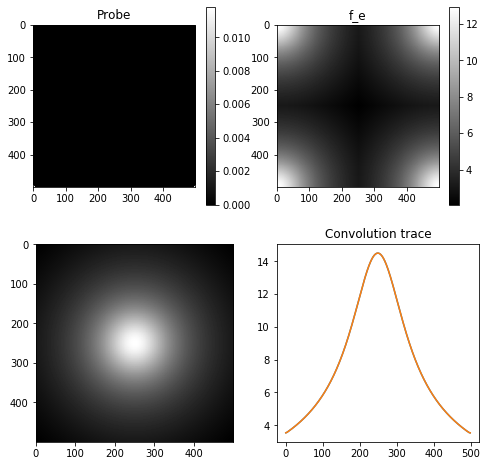

250


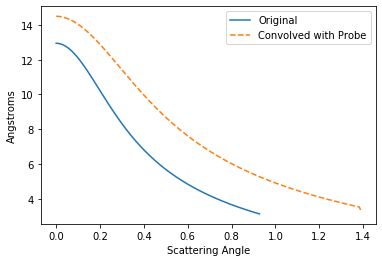

In [15]:
N = 2*q_arr.shape[0]
print(N)
E0 = 200e3
semiangle = 0.51 /1000 #normalize mrad to rad
grid_vec = np.linspace(-np.max(q_arr),np.max(q_arr),N,endpoint=True)
qya,qxa = np.meshgrid(grid_vec,grid_vec)
qya = np.fft.fftshift(qya)
qxa = np.fft.fftshift(qxa)
dq = (qxa[1,0] + qya[0,1]) / 2
print(dq)
probe = (createProbe(qxa,qya,dq,getLambda(E0),semiangle).real)
q2 = qxa**2+qya**2
fe = electron_scattering_factor(73,q2,units= "A")
#I = np.fft.fftshift(convolve2d(np.fft.fftshift(probe),np.fft.fftshift(fe)[::-1,::-1],mode='same'))
# # convovlve thru ffts
I = (np.fft.ifft2(np.fft.fft2(fe)*np.fft.fft2(probe)).real)
I_trace = np.fft.fftshift(I)[:,N//2]
I_trace2 = np.fft.fftshift(I)[N//2,:]

fig, ((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(8,8))

im = ax11.imshow((probe))
ax11.set_title("Probe")
fig.colorbar(im,ax=ax11)

im = ax12.imshow((fe))
ax12.set_title("f_e")
fig.colorbar(im,ax=ax12)

im = ax21.imshow(np.fft.fftshift(I))
# ax21.set_title()
# fig.colorbar(im,ax=ax21)

ax22.plot(I_trace)
ax22.plot(I_trace2)
ax22.set_title("Convolution trace")

plt.show()

r_range = [0,N//2]
dr = 1 #pixels
dtheta = np.radians(1) # degrees -> radians

Nx = I.shape[0]
Ny = I.shape[1]
yy,xx = np.meshgrid(np.arange(Ny),np.arange(Nx))

coefs = np.array([N//2,N//2,1,1,0])
# Polar coordinates
r_bins = np.arange(r_range[0]+dr/2.,r_range[1]+dr/2.,dr) # values
t_bins = np.arange(-np.pi+dtheta/2.,np.pi+dtheta/2.,dtheta) # are bin centers
Nr, Nt = len(r_bins),len(t_bins)
rr, tt = np.meshgrid(r_bins, t_bins)

xr = rr * np.cos(tt)
yr = rr * np.sin(tt)
x = coefs[0] + xr*coefs[2]*np.cos(coefs[4]) - \
                    yr*coefs[3]*np.sin(coefs[4])
y = coefs[1] + yr*coefs[3]*np.cos(coefs[4]) + \
                    xr*coefs[2]*np.sin(coefs[4])

transform_mask = (x>0)*(y>0)*(x<Nx-1)*(y<Ny-1)
xF = np.floor(x[transform_mask])
yF = np.floor(y[transform_mask])
dx = x[transform_mask] - xF
dy = y[transform_mask] - yF

x_inds = np.vstack((xF,xF+1,xF  ,xF+1)).astype(int)
y_inds = np.vstack((yF,yF,  yF+1,yF+1)).astype(int)
weights = np.vstack(((1-dx)*(1-dy),
                        (  dx)*(1-dy),
                        (1-dx)*(  dy),
                        (  dx)*(  dy)))

transform_mask = transform_mask.ravel()
polar_ar = np.zeros(np.prod(rr.shape))        # Bilinear interpolation happens
polar_ar[transform_mask] = np.sum(np.fft.fftshift(I)[x_inds,y_inds]*weights,axis=0) #    <-----here 
polar_ar = np.reshape(polar_ar,rr.shape)


abcissa=np.arange(0,Nr)*dq
print(Nr)
fe = electron_scattering_factor(73,np.square(q_arr),units= "A")
cfe = (np.mean(polar_ar,axis=0))
plt.plot(q_arr,fe,label='Original')
plt.plot(abcissa,cfe,linestyle='--',label='Convolved with Probe')
plt.xlabel('Scattering Angle')
plt.ylabel('Angstroms')

plt.legend()
plt.show()

(250,)
(250,)


(-3, 3)

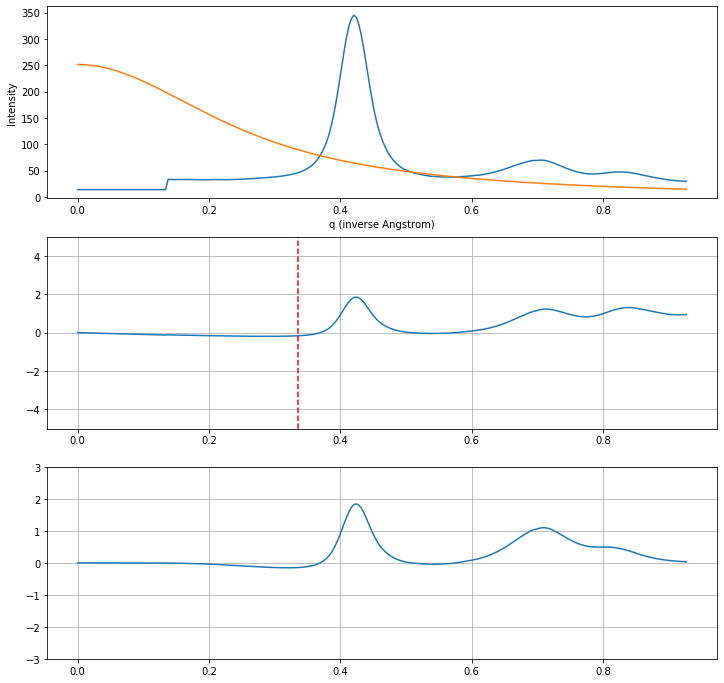

In [16]:
scale = 1.5
idx = 36
yMean2 = np.copy(yMean)
# print(yMean2[35])
yMean2[0:idx+1] = 13.85
# print(yMean2[35])
fig1,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,12))
ax1.plot(q_arr, yMean2)
# ax1.set_ylim(0,25)
ax1.set_xlabel('q (inverse Angstrom)')
ax1.set_ylabel('Intensity')
ax1.plot(q_arr,scale*fe**2)
norm_Is = (yMean2-scale*fe**2)/(scale*fe**2)
exp_kernel = np.ones(yMean2.shape[0])
k = .02
idx = 90
exp_kernel[0:idx] = np.exp(k*(np.arange(idx)-idx))
phi = (norm_Is*q_arr)#*exp_kernel
ax2.plot(q_arr,phi)
ax2.grid()
ax2.axvline(x=q_arr[idx],linestyle='--',color='r')
ax2.set_ylim(-5,5)
# ax2.set_ylim(-1000,1000)
vec = np.linspace(q_arr[0],q_arr[len(q_arr)//2],len(q_arr)//2)
vec2 = np.linspace(q_arr[len(q_arr)//2],q_arr[-1],len(q_arr)//2)
mask_x = np.concatenate((vec,vec2),axis=0)
print(mask_x.shape)
print(q_arr.shape)
mask_y = (np.concatenate((erf(10*vec-2.5),erf(8-10*vec2)),axis=0)+1)/2
ax3.plot(q_arr,mask_y*phi)
ax3.grid()
ax3.set_ylim(-3,3)

In [17]:
import scipy.integrate as sint

def sineFourier(q,r,phi):
    #assumes numerical integrand produced from mesh grid of:
    #q, increasing left to right
    #r, increasing top to bottom
    q_grid,r_grid = np.meshgrid(q,r)
    phi = np.ones(q_grid.shape)*phi #broadcast phi
    integrand = phi*np.sin(q_grid*r_grid)
    
    return sint.simps(y=integrand,x=q,axis=1)

In [18]:
Ta_rdf = np.load('/home/lerandc/gitRepos/SULI2019/Ta_2Dz.npy')
#np.load('/media/lerandc/DATA/files/Amorphous_simulations/Ta_rdf_data.npy')

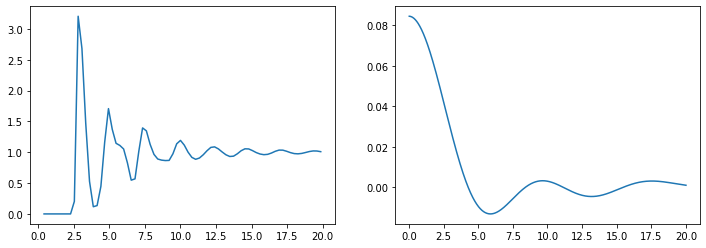

In [19]:
fig, (ax11,ax12) = plt.subplots(1,2,figsize=(12,4))
r_arr=np.linspace(0,20,1000)
# G_r = 4*sineFourier(q=q_arr,r=r_arr,phi=phi)


q_grid,r_grid = np.meshgrid(q_arr,r_arr)
phi_grid = np.ones(q_grid.shape)*phi #broadcast phi
integrand = phi_grid*np.sin(q_grid*r_grid)
G_r = 4*sint.simps(y=integrand,x=q_arr,axis=1)

ax11.plot(Ta_rdf.item()['bins'][1:],Ta_rdf.item()['rdf'][1:])
ax12.plot(r_arr[1:],G_r[1:]/(4*np.pi*r_arr[1:]))

/home/lerandc/.local/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


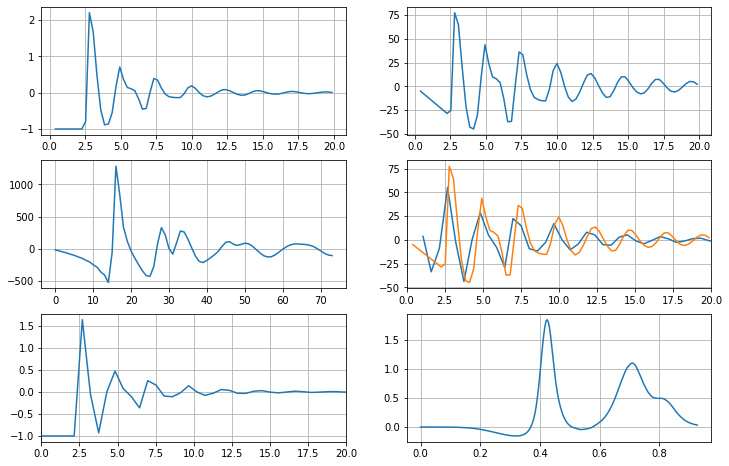

In [20]:
rho_0 = 1024000/((282.483-13.8777)**3) #mean number density as N/cubic angstrom
g_r_ref = Ta_rdf.item()['rdf'][1:]-1
r_ref = Ta_rdf.item()['bins'][1:]
G_r_ref = 4*np.pi*r_ref*(g_r_ref)
fig,((ax11,ax12),(ax21,ax22),(ax31,ax32)) = plt.subplots(3,2,figsize=(12,8))

q_grid,r_grid = np.meshgrid(q_arr,r_ref)
G_r_grid = np.ones(r_grid.shape)*np.expand_dims(G_r_ref,axis=1) #broadcast G_r
integrand = G_r_grid*np.sin(q_grid*r_grid)
phi_ref = sint.simps(y=integrand,x=r_ref,axis=0)

from scipy.fftpack import dst, idst

ax11.plot(r_ref,g_r_ref)
ax11.grid()
ax12.plot(r_ref,G_r_ref)
ax12.grid()

ax21.plot(dst(G_r_ref))
ax21.grid()

sample_freq = 1/(q_arr[1]-q_arr[0])
r_test = (np.arange(q_arr.shape[0])/q_arr.shape[0])*sample_freq#/np.sqrt(np.pi)
# shift_ratio = r_ref[np.argmax(G_r_ref)]/r_test[np.argmax(G_r_test[1:])+1]
# shift_ratio2 = (1/np.sqrt(np.pi))
r_test = r_test*0.5#shift_ratio

G_r_test = idst(phi,type=2)*(1/np.sqrt(2))
ax22.plot(r_test[2:],G_r_test[2:])
ax22.plot(r_ref,G_r_ref)
ax22.grid()
ax22.set_xlim(0,20)

g_r_test = (G_r_test)/(4*np.pi*r_test)
flatten_mask = r_test < 2.3
g_r_test[flatten_mask] = -1
ax31.plot(r_test,g_r_test)
ax31.set_xlim(0,20)
# ax31.set_ylim(-1,3)
ax31.grid()

ax32.plot(q_arr,mask_y*phi)
ax32.grid()

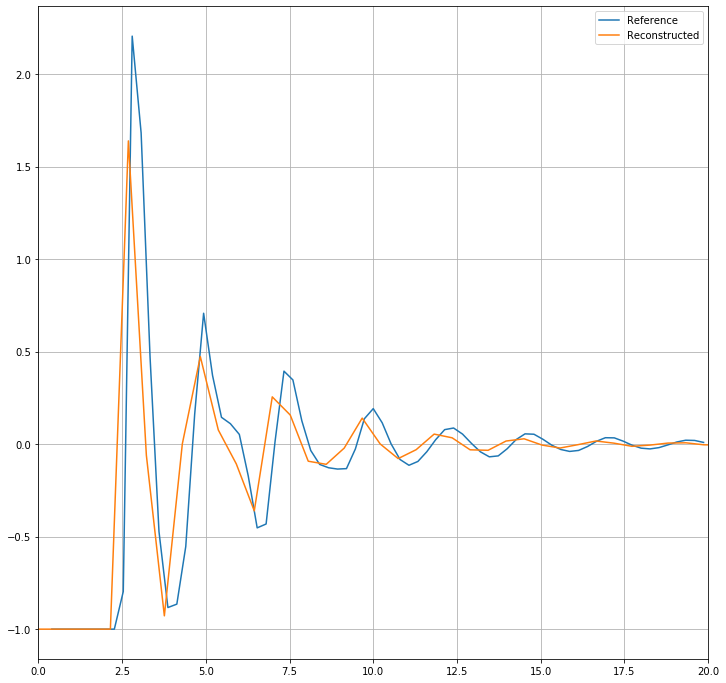

In [21]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
ax.plot(r_ref,g_r_ref,label='Reference')
ax.plot(r_test,g_r_test,label='Reconstructed')
ax.legend()
ax.set_xlim(0,20)
ax.grid()

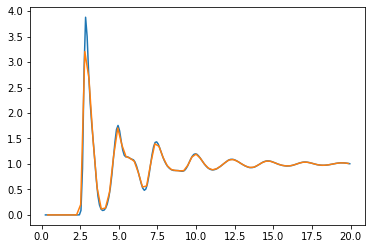

In [25]:
Ta_3D = np.load('/media/lerandc/DATA/files/Amorphous_simulations/Ta_rdf_data.npy')
plt.plot(Ta_3D.item()['bins'][1:],Ta_3D.item()['rdf'][1:])
plt.plot(r_ref,g_r_ref+1)